In [121]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/leonidasf300/dl22_2/main/content/init.py
import init; init.init(force_download=False); 

In [122]:
#instalar librerias utiles
import pandas as pd
import numpy as np
import io
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import median
from datetime import datetime, timedelta, date
from copy import copy
import random
import json

from sklearn.linear_model import LinearRegression, Lasso

# **Energy forecasting**

Los datos son tomados de kaggle. 

Fuente: [Energy forecasting](http://blog.drhongtao.com/2016/10/gefcom2017-hierarchical-probabilistic-load-forecasting.html)

Tamaño en disco: 19.1 MB
Cantidad de datos: 43824

In [123]:
dem_hist0 = pd.read_excel('local/data/GEFCom2013-2017.xlsx',sheet_name='ISO NE CA') 
dem_hist0

,Date,Hour,DA_DEMD,DEMAND,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,DryBulb,DewPnt,SYSLoad,RegCP,Unnamed: 16
0,2013-01-01,1,11828.0,12598.000,79.80,79.34,0.00,0.46,99.23,98.56,0.00,0.67,33,22,12825.0,11.00,NaN
1,2013-01-01,2,11785.0,11953.000,66.28,65.81,0.00,0.47,120.08,119.20,0.00,0.88,33,22,12167.0,7.34,NaN
2,2013-01-01,3,11600.0,11489.000,68.89,68.47,0.00,0.42,35.71,35.41,0.00,0.30,33,22,11697.0,6.77,NaN
3,2013-01-01,4,11252.0,11239.000,50.22,50.01,0.00,0.21,32.87,32.61,0.00,0.26,34,22,11440.0,7.15,NaN
4,2013-01-01,5,11399.0,11253.000,51.67,51.47,0.00,0.20,35.44,35.14,0.00,0.30,33,22,11450.0,6.80,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2017-12-31,20,1531.1,1696.392,212.49,217.30,0.00,-4.81,179.49,188.42,-1.73,-7.20,2,-11,NaN,NaN,NaN
43820,2017-12-31,21,1459.3,1652.438,209.58,215.37,-0.37,-5.42,164.02,172.41,-1.31,-7.08,1,-12,NaN,NaN,NaN
43821,2017-12-31,22,1352.6,1577.769,176.66,182.20,0.00,-5.54,132.54,140.41,-1.81,-6.06,0,-12,NaN,NaN,NaN
43822,2017-12-31,23,1189.0,1523.502,161.28,166.99,-0.50,-5.21,149.22,158.45,-2.41,-6.82,-1,-14,NaN,NaN,NaN


In [124]:
# Días para entrenar
dq=30
ndd = int(565+31) # ndd: numero de dias para entrenar
d_atr = 90 #Cantidad de días atras del día donde terminan los datos de entrenamiento.
#fecha de inicio de datos de entrenamiento
d_cero = date(2015,1,1) #d_cero: dia cero
# Fecha inicial de pronostico
d_fin = date(2015,1,1)+(565+31-15)*timedelta(days=1) # Día donde terminan los datos de entrenamiento

# Fechas entre las que estaran los datos para sacar valores tipicos.
f_fin = d_fin - d_atr*timedelta(days=1)
f_ini = f_fin - 180*timedelta(days=1) # 180 es la forma de calular 6 meses de manera rapida (6*30=180)

if f_ini < d_cero:
    print('Error: Usted selecciono un dia inicial, para calcular los valores, tipicos no permitido')

In [125]:
indices = pd.date_range(start=dem_hist0['Date'].iloc[0],end =dem_hist0['Date'].iloc[-1]+timedelta(hours=23), freq='h')
meteo_hist=pd.DataFrame()
meteo_hist['T_DryBulb'] = list(dem_hist0['DryBulb']) #traer datos de la base de datos inicial
meteo_hist['T_DewPnt'] = list(dem_hist0['DewPnt']) #traer datos de la base de datos inicial
meteo_hist.index = indices

In [126]:
#Crear dataframe con estructura del codigo
l_horas = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
indices = pd.date_range(start=dem_hist0['Date'].iloc[0],end =dem_hist0['Date'].iloc[-1], freq='D')
df_zona1_dem_t=pd.DataFrame(columns=l_horas, index=indices) # se creael data frame con la informacion de demanda
for i in l_horas:
    lista = dem_hist0.index[dem_hist0['Hour']==int(i)+1].tolist() #se busca la demdanda de cada hora. Por ejemplo: todos los indices de las demandas de la 1.
    df_zona1_dem_t[i]=dem_hist0['DEMAND'].iloc[lista].tolist() # se busca la demanda y se agrega al nuevo dataframe

df_zona1_dem_t.insert(0,'Zona','ISO NE CA',allow_duplicates=False) # se agrega una columna con la informacion de la zona
df_zona1_dem_t.insert(0,'Fecha',indices,allow_duplicates=False) # se agrega un columna con la informacion de la fecha

In [127]:
# Escalar los datos de demanda

# Aumentar las unidades de los datos para mayor facilidad con los numeros. De MW a GW.
df_zona1_dem_t[l_horas] = df_zona1_dem_t[l_horas]

df_minmax = df_zona1_dem_t[d_cero:d_cero + (ndd-15)*timedelta(days=1)]# dataframe que se utilizará para sacar los minimos y maximos, teniendo en cuenta que solo se debe usar la informacion de entrenamiento
# Se encuantran los valores minimos y maximos de todo el dataframe.
v_min = df_minmax[l_horas].min(skipna=True).min(skipna=True) # v_min: valor minimo
v_max = df_minmax[l_horas].max(skipna=True).max(skipna=True) # v_max: valor maximo

df_zona1_dem_t[l_horas] = (df_zona1_dem_t[l_horas] - v_min)/(v_max-v_min)

In [128]:
#se resetean los indices de df_zona1_dem_t
df_zona1_dem_t = df_zona1_dem_t.reset_index(drop=True)

#se le quitan 'dq' días a la base de datos, para comparar con datos completamente crudos.
df_zona1_dem = df_zona1_dem_t.iloc[:]
df_zona1_dem_p = df_zona1_dem_t.iloc[len(df_zona1_dem)-dq:] # la p quiere decir prueba


# dat_zona: Cantidad de datos por zona
dat_zona = len(df_zona1_dem)

In [129]:
#Datos en cero por columna
(df_zona1_dem == 0).sum(axis=0)

Fecha    0
Zona     0
0        0
1        3
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
dtype: int64

In [130]:
#porcentaje exacto de datos en cero
suma=0
for i in l_horas:
    suma+=len(df_zona1_dem.index[df_zona1_dem[i]==int(0)].tolist())
print('el porcentaje de datos en cero es: ',(suma/(ndd*24))*100)

el porcentaje de datos en cero es:  0.02097315436241611


In [131]:
#cambiar el indice del dataframe con la informacion a fechas para mas facil manejo
df_zona1_dem.index = indices

#identificar los dias de la semana y agregarlos al dataframe
df_zona1_dem = pd.concat([df_zona1_dem,pd.DataFrame(df_zona1_dem.index.strftime("%w"), columns=["d_w"], index=indices)],axis=1)

## Dias festivos
us_festivos = holidays.US()
#col_festivos = holidays.COL()
ind_festivos = pd.DataFrame(index=indices ,columns=['festivo'])
for i in indices:
    ind_festivos.loc[i,'festivo'] = i in us_festivos
c_festivos = ind_festivos[ind_festivos["festivo"]==True].index #Guardar los días festivos en una lista para facilitar su manipulación. 
ind_festivos=ind_festivos.replace([True,False],[1,0])
df_zona1_dem = pd.concat([df_zona1_dem,ind_festivos],axis=1)

In [132]:
### Dias Lunes festivos (DLF) y Dias festivos no lunes (DFNL)
dlf = pd.DataFrame(index=indices ,columns=['dlf'])
dfnl = pd.DataFrame(index=indices ,columns=['dfnl'])
for i in indices:
  if df_zona1_dem['festivo'].loc[i] == 1:
    if df_zona1_dem['d_w'].loc[i] == '1':
      dlf['dlf'].loc[i] = 1
      dfnl['dfnl'].loc[i] = 0
    else:
      dfnl['dfnl'].loc[i] = 1
      dlf['dlf'].loc[i] = 0
  else:
    dlf['dlf'].loc[i] = 0
    dfnl['dfnl'].loc[i] = 0

df_zona1_dem = pd.concat([df_zona1_dem,dlf,dfnl],axis=1)

In [133]:
# Indicar los dias que estan cercanos a los festivos 

#creamos un delta de tiempo de un día 
un_dia = timedelta(days=1)
l_cf = [] #creamos una lista con los días cercanos a los festivos
dias_atras = [3,2,1] # días atras tenidos en cuenta
dias_delante = [1]

#for para ir llenando la lista
for i in range(0,len(c_festivos)):
# se agregan lso condicionales if y elif para no salirse
# del rango de los datos originales
  if c_festivos[i] == indices[0]:
    for j in dias_delante:
      l_cf.append(c_festivos[i]+j*un_dia)
  elif c_festivos[i] == indices[len(indices)-1]:
    for j in dias_atras:
      l_cf.append(c_festivos[i]-j*un_dia)
  else:
    for j in dias_atras:
      l_cf.append(c_festivos[i]-j*un_dia)
    for j in dias_delante:
      l_cf.append(c_festivos[i]+j*un_dia)

# Se agregan en el datafrem con toda la informacion los dias cercanos a
# días festivos, todavía no se ponen en variables dumming
df_zona1_dem.loc[l_cf,'D_cf'] = df_zona1_dem.loc[l_cf].index.strftime("%w")

#Remplazar los numeros que identifican los dias de la semana por las
# letras que indican que día es, pero haciendo enfasis en que se hace referencia
# a los dias cercanos a festivos.
df_zona1_dem['D_cf'] = df_zona1_dem['D_cf'].replace({'0': 'd_cf', '1': 'l_cf',
                                              '2': 'm_cf', '3': 'w_cf',
                                              '4': 'j_cf', '5': 'v_cf',
                                              '6': 's_cf'})

In [134]:
#Remplazar los numeros que identifican los dias de la semana por letras iniciales
df_zona1_dem.d_w = df_zona1_dem.d_w.replace({'0': 'd', '1': 'l', '2': 'm',
                                            '3': 'w', '4': 'j', '5': 'v',
                                            '6':'s'})

In [135]:
# Identificar indices para saber cuales dias de la semana son festivos o no festivos
id_cal_med = {} #id_cal_med: indices para calculo de las medias y desviaciones estandar
for d in ['l','m','w','j','v','s','d']:
  id_cal_med[d+'nf'] = [] # nf: No Festivo
  id_cal_med[d+'f'] = [] # f: Festivo
  for i in indices:
  #Identificar los dias festivos y no festivos, teniendo en cuanta el tipo de día:
    if df_zona1_dem['d_w'].loc[i] == d:
      if df_zona1_dem['festivo'].loc[i] == 1:
        id_cal_med[d+'f'].append(i)
      else:
        id_cal_med[d+'nf'].append(i)

#Se deja que el codigo identifique los domingos y sabados festivos
#debido a que estos corresponden en su mayoria a días muy atipicos.

In [136]:
#eliminar la llave que no tenga ningun día.
for d in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    if id_cal_med[d+k]==[]:
      del id_cal_med[d+k]

In [137]:
#Calculo de las medianas horarias dependiendo del día
medias = {}
for j in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    for i in range(0,24):
      try:
        medias['h'+str(i)+'_'+j+k]=(df_zona1_dem[str(i)].
                                  loc[id_cal_med[j+k]].median())
      except:
        print('no se tienen', j+k, 'en la base de datos')
        break

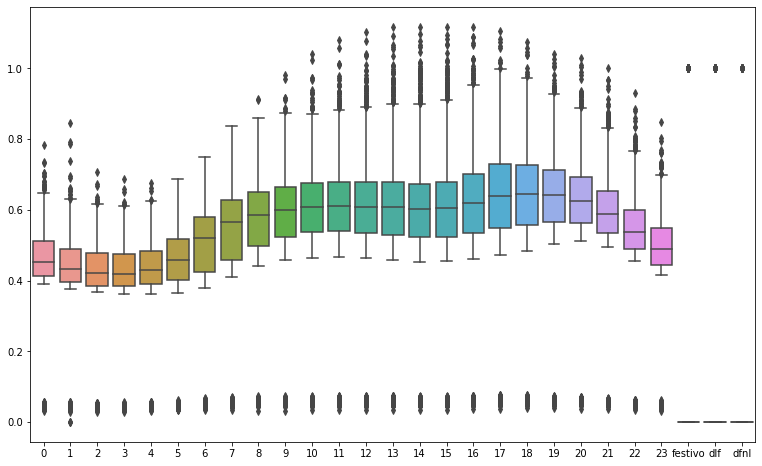

In [138]:
# Boxplot para la información de demanda.
plt.figure(figsize=(13, 8))
sns.boxplot(data=df_zona1_dem)

In [139]:
# Se llenan los datos faltantes del dataframe con las medianas
for h in l_horas:
    id_dfalta = df_zona1_dem[df_zona1_dem[h].isnull()].index # id_dfalta: Indicies de los datos faltantes.
    for d in ['l','m','w','j','v','s','d']:
        for i in id_dfalta:
            if df_zona1_dem['d_w'].loc[i] == d:
                if df_zona1_dem['festivo'].loc[i] == 1:
                    df_zona1_dem[h].loc[i] = medias['h'+h+'_'+d+'f']
                else:
                    df_zona1_dem[h].loc[i] = medias['h'+h+'_'+d+'nf']
# Se cambian los datos en cero con las medias cuando el usuario decida tarabajar sin datos en cero.
print('Se cambiarán los datos en cero por las medianas')
for h in l_horas:
    id_dcero=df_zona1_dem.index[df_zona1_dem[h]==int(0)].tolist() #lista de id de los datos en cero
    for d in ['l','m','w','j','v','s','d']:
        for i in id_dcero:
            if df_zona1_dem['d_w'].loc[i] == d:
                if df_zona1_dem['festivo'].loc[i] == 1:
                    df_zona1_dem.loc[i,h] = medias['h'+h+'_'+d+'f']
                else:
                    df_zona1_dem.loc[i,h] = medias['h'+h+'_'+d+'nf']

Se cambiarán los datos en cero por las medianas


In [140]:
#Se seleccionana solo los datos con los que se va a entrenar
df_zona1_dem = df_zona1_dem.loc[pd.date_range(start=d_cero,
                            end =d_cero+ndd*timedelta(days=1),
                            freq='d')]
# Se crea un data frame con sin datos dañados, para facilitar el calculo de los datos tipicos
df_zona1_dem_nul =  df_zona1_dem.loc[pd.date_range(start=d_cero,
                            end =d_cero+ndd*timedelta(days=1),
                            freq='d')]

In [141]:

data_tipica = df_zona1_dem_nul.loc[f_ini:f_fin]# parte de la base de datos que no se va a dañar y de donde se sacarán los datos tipicos.

In [142]:
data_tipica_dic = {}
for i in range(0,24):
    id_aux = data_tipica[str(i)].dropna().index
    data_tipica_dic[i] = data_tipica.loc[id_aux,[str(i),'d_w','festivo','dlf','dfnl','D_cf']]
    del(id_aux)


In [143]:
# Identificar indices para saber cuales dias de la semana son festivos o no festivos
id_cal_med = {} #id_cal_med: indices para calculo de las medias y desviaciones estandar
for d in ['l','m','w','j','v','s','d']:
  for h in range(0,24):
    id_cal_med[d+'nf_'+str(h)] = [] # nf: No Festivo
    id_cal_med[d+'f_'+str(h)] = [] # f: Festivo
    id_cal_med[d+'_'+str(h)] = [] # d: día de la semana
    for i in data_tipica_dic[h].index:
    #Identificar los dias festivos y no festivos, teniendo en cuanta el tipo de día:
      if data_tipica_dic[h]['d_w'].loc[i] == d:
        id_cal_med[d+'_'+str(h)].append(i)
        if data_tipica_dic[h]['festivo'].loc[i] == 1:
          id_cal_med[d+'f_'+str(h)].append(i)
        else:
          id_cal_med[d+'nf_'+str(h)].append(i)

#Se deja que el codigo identifique los domingos y sabados festivos
#debido a que estos corresponden en su mayoria a días muy atipicos.

In [144]:
# Se recalculan las medianas horarias dependiendo del día
medianas={}
for j in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    for i in range(0,24):
      try:
        if pd.isna(data_tipica_dic[i][str(i)].loc[id_cal_med[j+k+'_'+str(i)]].median()):
          medianas['h'+str(i)+'_'+j+k]=(data_tipica_dic[i][str(i)].
                                  loc[id_cal_med[j+'_'+str(i)]].median())
        else:
          medianas['h'+str(i)+'_'+j+k]=(data_tipica_dic[i][str(i)].
                                  loc[id_cal_med[j+k+'_'+str(i)]].median())
      except:
        print('no se tienen', j+k+str(i), 'en la base de datos para la media')
        break

# Se recalculan las medias horarias dependiendo del día
medias={}
for j in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    for i in range(0,24):
      try:
        if pd.isna(data_tipica_dic[i][str(i)].loc[id_cal_med[j+k+'_'+str(i)]].mean()):
          medias['h'+str(i)+'_'+j+k]=(data_tipica_dic[i][str(i)].
                                  loc[id_cal_med[j+'_'+str(i)]].mean())
        else:
          medias['h'+str(i)+'_'+j+k]=(data_tipica_dic[i][str(i)].
                                  loc[id_cal_med[j+k+'_'+str(i)]].mean())
      except:
        print('no se tienen', j+k+str(i), 'en la base de datos para la media')
        break

In [145]:
l_hd = [] #l_hd: lista horas del día
for i in range(0,24):
    l_hd.append(str(i))

id_sin_nul = data_tipica[l_hd].dropna().index # indices que contienen los indices de los días que no tienen ninguna hora con datos faltantes
df_sin_nul = data_tipica.loc[id_sin_nul,l_hd+['d_w','festivo','dlf','dfnl','D_cf']]

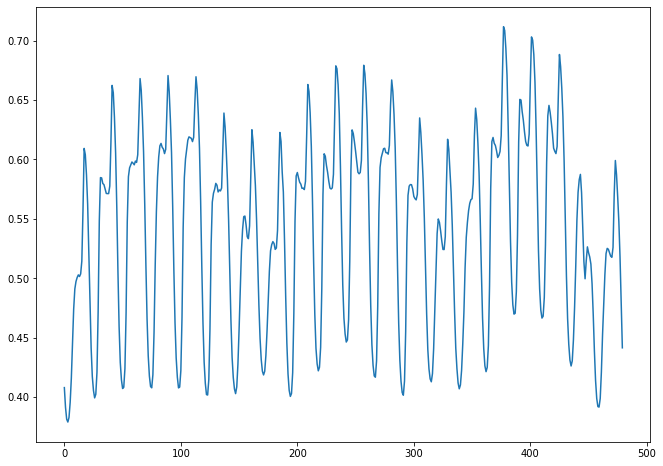

In [146]:
#Grafica para visualizar si con los días que quedaron, al elminiar los NAN, se tiene una buena curva de demanda.
df_transp = data_tipica.loc[id_sin_nul,l_hd].transpose()
prueba_df = pd.DataFrame(columns=['Data'])
for i in df_transp.columns:
    prueba_df = pd.concat([prueba_df,df_transp[i]], axis=0)

prueba_df = prueba_df.reset_index()

plt.figure(figsize=(11, 8))
plt.plot(prueba_df.index[:24*20],prueba_df[0][:24*20],'-')#,label = 'Coef hora '+str(i), linewidth=2,alpha = 1.00)
plt.show()

In [147]:
# Identificar indices para saber cuales dias de la semana son festivos o no festivos
id_cal_med_d = {} #id_cal_med_d: indices para calculo de las medias y desviaciones estandar diarias
for d in ['l','m','w','j','v','s','d']:
  id_cal_med_d[d+'nf'] = [] # nf: No Festivo
  id_cal_med_d[d+'f'] = [] # f: Festivo
  id_cal_med_d[d] = [] # d: día de la semana
  for i in df_sin_nul.index:
  #Identificar los dias festivos y no festivos, teniendo en cuanta el tipo de día:
    if df_sin_nul['d_w'].loc[i] == d:
      id_cal_med_d[d].append(i)
      if df_sin_nul['festivo'].loc[i] == 1:
        id_cal_med_d[d+'f'].append(i)
      else:
        id_cal_med_d[d+'nf'].append(i)

#Se deja que el codigo identifique los domingos y sabados festivos
#debido a que estos corresponden en su mayoria a días muy atipicos.

In [148]:
# Encontrar la demanda tipica de cada día #
# Se procede a calcular la suma de la demanda en cada día.

df_sin_nul['D_d'] = df_sin_nul[l_hd].sum(axis=1) #D_d: Demanda diaria

#Calculo de las medianas díarias teniendo en cuenta si es festivo o no
medianas_d = {} #medianas_d: medianas diarias.
for j in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    try:
      if pd.isna(df_sin_nul['D_d'].loc[id_cal_med_d[j+k]].median()):
        medianas_d[j+'_'+k]=(df_sin_nul['D_d'].
                                  loc[id_cal_med_d[j]].median())
      else:
        medianas_d[j+'_'+k]=(df_sin_nul['D_d'].
                                  loc[id_cal_med_d[j+k]].median())
    except:
      print('no se tienen', j+k, 'en la base de datos')

#Calculo de las medias díarias teniendo en cuenta si es festivo o no
medias_d = {} #medias_d: medias diarias.
for j in ['l','m','w','j','v','s','d']:
    for k in ['f','nf']:
        try:
          if pd.isna(df_sin_nul['D_d'].loc[id_cal_med_d[j+k]].mean()):
            medias_d[j+'_'+k]=(df_sin_nul['D_d'].
                                  loc[id_cal_med_d[j]].mean())
          else:
            medias_d[j+'_'+k]=(df_sin_nul['D_d'].
                                loc[id_cal_med_d[j+k]].mean())
        except:
            print('no se tienen', j+k, 'en la base de datos')

In [149]:
# Se calcula las desviaciones estandar diarias
suma_d={}
cont_d={}
desviacion_d={}
for j in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    try:
      if ((df_sin_nul['D_d'].loc[id_cal_med_d[j+k]]
          - medias_d[j+'_'+k])**2).sum() == 0:
        suma_d[j+k] =(((df_sin_nul['D_d'].
                                    loc[id_cal_med_d[j]]
                                    - medias_d[j+'_'+k])**2).sum())
        cont_d[j+k] = len(id_cal_med_d[j])
        #Calculo de las desviacion estandar
        desviacion_d[j+'_'+k] = (sqrt(suma_d[j+k]/
                                            (cont_d[j+k])))
      else:
        suma_d[j+k] =(((df_sin_nul['D_d'].
                                    loc[id_cal_med_d[j+k]]
                                    - medias_d[j+'_'+k])**2).sum())
        cont_d[j+k] = len(id_cal_med_d[j+k])
        #Calculo de las desviacion estandar
        desviacion_d[j+'_'+k] = (sqrt(suma_d[j+k]/
                                            (cont_d[j+k])))
    except:
      print('no se tienen', j+k, 'en la base de datos para la desviación')

In [150]:
# Se calcula las desviaciones estandar horarias dependiendo del día
suma2={}
cont={}
desviacion={}
for j in ['l','m','w','j','v','s','d']:
  for k in ['f','nf']:
    for i in range(0,24):
      try:
        if ((data_tipica_dic[i][str(i)].loc[id_cal_med[j+k+'_'+str(i)]]
            - medias['h'+str(i)+'_'+j+k])**2).sum() == 0:
          suma2['h'+str(i)+'_'+j+k] =(((data_tipica_dic[i][str(i)].
                                      loc[id_cal_med[j+'_'+str(i)]]
                                      - medias['h'+str(i)+'_'+j+k])**2).sum())
          cont['h'+str(i)+'_'+j+k] = len(id_cal_med[j+'_'+str(i)])
          #Calculo de las desviacion estandar
          desviacion['h'+str(i)+'_'+j+k] = (sqrt(suma2['h'+str(i)+'_'+j+k]/
                                              (cont['h'+str(i)+'_'+j+k])))
        else:
          suma2['h'+str(i)+'_'+j+k] =(((data_tipica_dic[i][str(i)].
                                      loc[id_cal_med[j+k+'_'+str(i)]]
                                      - medias['h'+str(i)+'_'+j+k])**2).sum())
          cont['h'+str(i)+'_'+j+k] = len(id_cal_med[j+k+'_'+str(i)])
          #Calculo de las desviacion estandar
          desviacion['h'+str(i)+'_'+j+k] = (sqrt(suma2['h'+str(i)+'_'+j+k]/
                                              (cont['h'+str(i)+'_'+j+k])))
      except:
        print('no se tienen', j+k, 'en la base de datos para la desviación')
        break

In [151]:
# Identificar indices para saber cuales dias de la semana son festivos o no festivos
cal_med_iloc = {} #cal_med_iloc: indices para calculo de las medias y desviaciones estandar diarias
for d in ['l','m','w','j','v','s','d']:
  cal_med_iloc[d+'nf'] = [] # nf: No Festivo
  cal_med_iloc[d+'f'] = [] # f: Festivo
  cal_med_iloc[d] = [] # d: día de la semana
  for j,i in enumerate(df_sin_nul.index):
  #Identificar los dias festivos y no festivos, teniendo en cuanta el tipo de día:
    if df_sin_nul['d_w'].loc[i] == d:
      cal_med_iloc[d].append(j)
      if df_sin_nul['festivo'].loc[i] == 1:
        cal_med_iloc[d+'f'].append(j)
      else:
        cal_med_iloc[d+'nf'].append(j)

#Se deja que el codigo identifique los domingos y sabados festivos
#debido a que estos corresponden en su mayoria a días muy atipicos.

In [152]:
# Se calculan las pendientes con el data frame que no tiene datos nulos en ninguno de sus días.
# Se crea un dataframe con la informacion no afectada por los daños en los datos
# Para sacar las pendientes de la demanda
id = list(range(0,(len(df_sin_nul))*24))

zona1_tipica = pd.DataFrame(index = id, columns=['Dem'])
k=0
for j in df_sin_nul.index:
  for i in range(0,24):
    zona1_tipica.iloc[k,0] = df_sin_nul.loc[j,str(i)]
    k+=1

In [153]:
#Calculo del cambio de la pendiente en cada hora
pendientes = pd.DataFrame(columns=range(0,24))
for i,k in enumerate(df_sin_nul.index[1:]):
  lista=[]
  for j in range(0,24):
    h=j + (i+1)*24
    lista.append(abs(zona1_tipica['Dem'].iloc[h]-zona1_tipica['Dem'].iloc[h-1]))
  pendientes.loc[i]=lista

In [154]:
#Crear dataframe en orden para los diccionarios
colum = ['Dem','T_DryBulb','T_DewPnt','fest','dlf','dfnl','D_cf','med','des','der','med_d','des_d']
id = pd.date_range(start=d_cero, freq="h", periods=24*ndd + 24)
zona1 = pd.DataFrame(index = id, columns=colum)

In [155]:
k=0
for j in pd.date_range(start=d_cero, freq='D', periods=ndd + 1):
  for i in range(0,24):
    zona1.iloc[k,0] = df_zona1_dem.loc[j,str(i)]
    #zona1['rad'].iloc[k] = df_zona1_tem.loc[j,str(i)]
    zona1.iloc[k,3] = df_zona1_dem.loc[j,'festivo']
    zona1.iloc[k,4] = df_zona1_dem.loc[j,'dlf']
    zona1.iloc[k,5] = df_zona1_dem.loc[j,'dfnl']
    zona1.iloc[k,6] = df_zona1_dem.loc[j,'D_cf']
    k=k+1

zona1['T_DryBulb'] = meteo_hist['T_DryBulb'].loc[pd.date_range(start=d_cero, freq='h', periods=24*ndd + 24)]
zona1['T_DewPnt'] =meteo_hist['T_DewPnt'].loc[pd.date_range(start=d_cero, freq='h', periods=24*ndd + 24)]


#dia de la semana
# El dia 0 corresponde a los domingos, el 1 a los lunes,
# así, hasta el 6 que serían los sabados.

zona1["d_s"] = zona1.index.strftime("%w") # d_s: Día de la semana
zona1.d_s = zona1.d_s.replace({'0': 'd', '1': 'l', '2':'m',
                              '3': 'w', '4': 'j', '5':'v',
                              '6': 's'})

#Crear dataframe con las columnas donde se indica que dia es
# en variables dumming
zona1 = pd.concat([zona1,pd.get_dummies(zona1.d_s)],axis=1)

#Crear dataframe con las columnas donde se indica que dia es,
# en variables dumming para los días cercanos a festivos
zona1 = pd.concat([zona1,pd.get_dummies(zona1.D_cf)],axis=1)

In [156]:
# Agregar medias y desviaciones al día y la hora que corresponde
for d in ['d','l','m','w','j','v','s']:
  for i in zona1.index:
    if zona1['d_s'].loc[i] == d:
      if zona1['fest'].loc[i] == 1:
        zona1.loc[i,'med'] = medianas['h'+str(i.hour)+'_'+d+'f']
        zona1.loc[i,'des'] = desviacion['h'+str(i.hour)+'_'+d+'f']
        #zona1.loc[i,'der'] = max_pendi['h'+str(i.hour)+'_'+d+'f']
        zona1.loc[i,'med_d'] = medianas_d[d+'_f']
        zona1.loc[i,'des_d'] = desviacion_d[d+'_f']
      else:
        zona1.loc[i,'med'] = medianas['h'+str(i.hour)+'_'+d+'nf']
        zona1.loc[i,'des'] = desviacion['h'+str(i.hour)+'_'+d+'nf']
        #zona1.loc[i,'der'] = max_pendi['h'+str(i.hour)+'_'+d+'nf']
        zona1.loc[i,'med_d'] = medianas_d[d+'_nf']
        zona1.loc[i,'des_d'] = desviacion_d[d+'_nf']


In [157]:
zona1.to_csv('data0_zone1.csv')